<a href="https://colab.research.google.com/github/Noam2710/StyleGAN_Interpolation/blob/master/Copy_of_style_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
!git clone https://github.com/NVlabs/stylegan.git

fatal: destination path 'stylegan' already exists and is not an empty directory.


In [0]:
import sys
sys.path.insert(0, "/content/stylegan")

import dnnlib
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib.tflib as tflib
import config
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import cv2
from matplotlib import pyplot as plt
list_of_models = ['vgg16','resnet50','senet50']
model_to_color = {'vgg16':'b','resnet50':'r','senet50':'g'}
list_of_algo = ['OpenAI']
algo_to_color = {'OpenAI':'b','CMA-ES':'r','RandomSearch':'g'}
fps_in_video = 5
image_size_in_video = (600,600)

In [0]:
tflib.init_tf()
with open('/content/drive/My Drive/karras2019stylegan-ffhq-1024x1024.pkl', "rb") as f:
  _G, _D, Gs = pickle.load(f)











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Source image


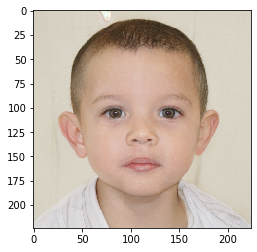

Destination image


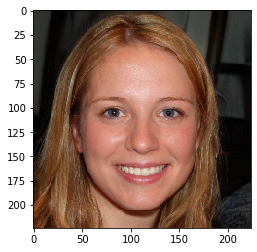

In [0]:
rnd = np.random.RandomState()
latents = rnd.randn(2, Gs.input_shape[1])
dest_latent = latents[1,np.newaxis]
source_latent = latents[0,np.newaxis]
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
source_image = np.squeeze(Gs.run(source_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
dest_image = np.squeeze(Gs.run(dest_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
print("Source image")
source_res = cv2.resize(np.squeeze(source_image), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(source_res)
plt.show()
print("Destination image")
dest_res = cv2.resize(np.squeeze(dest_image), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(dest_res)
plt.show()

In [0]:
!pip install evostra
from evostra import EvolutionStrategy

  Created wheel for evostra: filename=evostra-2.5.2-py2.py3-none-any.whl size=5628 sha256=5e7390e11cb229cb08f41c2c284051afee94b4f454b9898ba9977092564d44ee
  Stored in directory: /root/.cache/pip/wheels/8a/d2/0a/19e1279290da14ce7c3d25589e21f264037ac9fb38ae18aa55
Successfully built evostra


In [0]:
pip install keras_vggface

In [0]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image
from datetime import datetime

def predict_features_from_image(res):
  res = image.img_to_array(res)
  res = np.expand_dims(res, axis=0)
  res = utils.preprocess_input(res, version=2) # or version=2
  return vgg_features.predict(res)

Using TensorFlow backend.


In [0]:
def get_reward_by_vgg(latent_vector):
  image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
  image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  image_to_check_features = predict_features_from_image(image_after_resize)
  return -np.linalg.norm(image_to_check_features - features_of_dest_images)

def get_rewared_by_vgg_cosine(latent_vector):
  image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
  image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  image_to_check_features = predict_features_from_image(image_after_resize)
  return cosine_similarity(np.squeeze(image_to_check_features),np.squeeze(features_of_dest_images))*50

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [0]:
def run_es_model(verbose=False,run_each_time=2,total_runs=600):
  global features_of_dest_images
  features_of_dest_images = predict_features_from_image(dest_res)
  init_latent_vector = [source_latent]
  source_image = Gs.run(source_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
  res = cv2.resize(np.squeeze(source_image), dsize=image_size_in_video, interpolation=cv2.INTER_CUBIC)
  list_of_images = [cv2.cvtColor(res, cv2.COLOR_BGR2RGB)]
  list_of_vectors = []
  list_of_rewards = []
  es = EvolutionStrategy(init_latent_vector, get_reward_by_vgg, population_size=50, sigma=0.5, learning_rate=0.1, num_threads=1)
  for i in range (int(total_runs/run_each_time)):
    print("Iterations {} - {} | Reward {}".format(i*run_each_time,(i+1)*run_each_time,es.get_reward(es.get_weights())))
    es.run(run_each_time,print_step=run_each_time*10000)
    list_of_rewards.append(es.get_reward(es.get_weights()))
    list_of_vectors.append(np.squeeze(es.get_weights()[0]))
    images = Gs.run(es.get_weights()[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
    res = cv2.resize(np.squeeze(images), dsize=image_size_in_video, interpolation=cv2.INTER_CUBIC)
    if verbose:
      plt.imshow(res)
      plt.show()
    list_of_images.append(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
  return list_of_images,list_of_vectors,list_of_rewards

In [0]:
def print_graphs_for_feature_extraction_network(network_name):
  for algo in list_of_algo:
    plt.plot(list(range(1,len(model_to_rewards[network_name][algo])+1)),model_to_rewards[network_name][algo], algo_to_color[algo], label=algo)
  plt.title(network_name)
  plt.legend()
  plt.show()

In [0]:
def list_of_images_to_video(image_list,model_name,algo,date_time):  
  out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'mp4v'), fps_in_video, image_size_in_video)
  for i in range(len(images_list)):
      out.write(images_list[i])
  out.release()

  !mv 'project.avi' '/content/drive/My Drive/videos_of_transformation'
  os.rename('/content/drive/My Drive/videos_of_transformation/project.avi', '/content/drive/My Drive/videos_of_transformation/{}-{}--{}.avi'.format(model_name,algo,date_time))

In [0]:
features_of_dest_images = None
for model in list_of_models:
  model_to_rewards[model] = {}
  for algo in list_of_algo:
    now = datetime.now() # current date and time
    date_time = now.strftime("%m-%d-%Y-%H-%M-%S")
    vgg_features = VGGFace(model=model, include_top=False, input_shape=(224, 224, 3), pooling='avg')
    if algo == 'OpenAI':
      images_list,vectors_list,reward_list = run_es_model(verbose=False,run_each_time=2,total_runs=600)

    list_of_images_to_video(images_list,model,algo,date_time)
    model_to_rewards[model][algo] = reward_list

  print_graphs_for_feature_extraction_network(model)

Iterations 0 - 2 | Reward -97.2371826171875
Iterations 2 - 4 | Reward -87.9247817993164
Iterations 4 - 6 | Reward -87.55379486083984
Iterations 6 - 8 | Reward -84.81343078613281
Iterations 8 - 10 | Reward -81.64813232421875
Iterations 10 - 12 | Reward -79.54630279541016
Iterations 12 - 14 | Reward -78.39642333984375
Iterations 14 - 16 | Reward -76.61819458007812
Iterations 16 - 18 | Reward -76.10298156738281


KeyboardInterrupt: ignored